In [19]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [20]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 1

1

In [21]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0];

In [22]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     …  8.02953    8.61508   1.0  32.7318
 4.43494   8.65398   4.38668       4.26558    5.79587   0.0  10.2415
 7.45673   7.98071   9.35901       7.38559    9.99516   0.0  27.5137
 5.12083   8.25448   8.79223       0.835565   8.06585   0.0  24.796
 2.53849   5.30423   5.84012       0.570453   9.6668    0.0  22.6625
 3.34152   2.66141   9.8669     …  0.92876    9.49805   1.0  25.1241
 4.27328   8.75436   0.0258112     5.12688    2.24987   1.0   8.09666
 8.67547   7.27313   0.151025      0.0873517  0.765286  0.0  25.0373
 0.991336  1.20752   5.87184       8.38971    9.81301   0.0  20.8175
 1.25287   6.88003   3.64868       4.16181    3.00126   0.0  26.2578
 6.92209   0.298644  4.84843    …  8.07655    1.49476   0.0  36.4211
 1.36551   1.07227   0.570038      2.53062    7.60498   1.0  21.9686
 0.320967  6.45858   4.85281       9.74512    1.98433   0.0  32.6943
 ⋮                              ⋱                       ⋮    
 1.41477   4.12

In [23]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_3.csv", [header ; df], ",")

In [24]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = sin.(Xtest_1[:, 1]);

In [25]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [26]:
errors_11 = zeros(100)

cf = @btime build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = @btime apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

  400.307 s (110023402 allocations: 37.14 GiB)
  4.061 s (128329962 allocations: 2.37 GiB)
0.039744740467064325
1.0073983437365042e-6


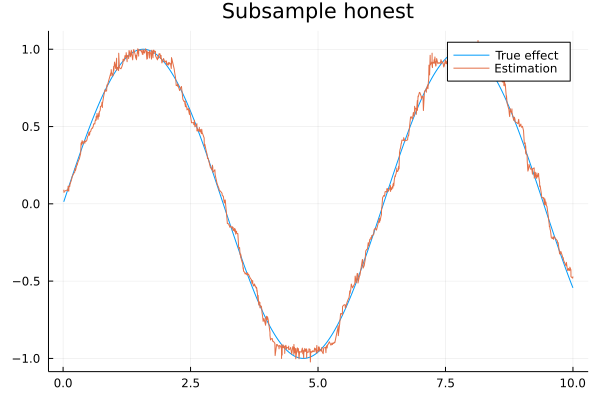

In [27]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsample honest", fmt = :png)

In [28]:
get_freq(cf, 3)

Dict{Any, Float64} with 3 entries:
  8 => 0.000285714
  3 => 0.000285714
  1 => 0.999429

In [29]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0351809
  4  => 0.031683
  6  => 0.0351809
  7  => 0.0435221
  2  => 0.0300686
  10 => 0.0290596
  9  => 0.0366608
  8  => 0.0306068
  3  => 0.0462801
  1  => 0.681757

In [30]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0802495
  4  => 0.0785052
  6  => 0.084127
  7  => 0.099035
  2  => 0.0828722
  10 => 0.0781538
  9  => 0.0779656
  8  => 0.077815
  3  => 0.0938398
  1  => 0.247437

### Bootstrap

In [31]:
errors_12 = zeros(100)

cf = @btime build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = @btime apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

  404.243 s (111177605 allocations: 37.32 GiB)
  4.326 s (138075556 allocations: 2.52 GiB)
0.03872318940194855
7.346943063875833e-7


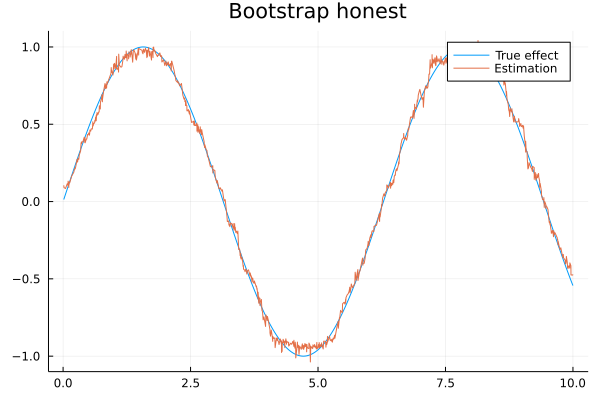

In [32]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [33]:
get_freq(cf, 3)

Dict{Any, Float64} with 8 entries:
  5 => 0.000571429
  4 => 0.000571429
  7 => 0.000285714
  2 => 0.000857143
  9 => 0.000285714
  8 => 0.000285714
  3 => 0.00285714
  1 => 0.994286

In [34]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0382979
  4  => 0.0334347
  6  => 0.0396488
  7  => 0.0501857
  2  => 0.0322188
  10 => 0.0304627
  9  => 0.0388382
  8  => 0.0327592
  3  => 0.0616008
  1  => 0.642553

In [35]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0828229
  4  => 0.0800533
  6  => 0.0865406
  7  => 0.0994194
  2  => 0.0846232
  10 => 0.0804474
  9  => 0.0835473
  8  => 0.0844847
  3  => 0.100985
  1  => 0.217076